In [2]:
from feast import FeatureStore, Entity, FeatureView, FeatureService, RequestSource, Field, FileSource, ValueType

In [3]:
fs = FeatureStore(repo_path="../feature_repo/feature_repo")

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_parquet("../data/processed/favorita_clean.parquet")

In [7]:
df.shape

(3054348, 17)

# Obtiene features históricas de Feast para entrenamiento.

In [8]:
training_df = fs.get_historical_features(
    entity_df=df[["store_nbr", "family", "date"]].sample(n=1000, random_state=42),
    features=["sales_store_view:sales", "sales_store_view:onpromotion", "sales_store_view:transactions", "sales_store_view:dcoilwtico", "sales_store_view:type_y"],
).to_df()

Using date as the event timestamp. To specify a column explicitly, please name it event_timestamp.


In [116]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   store_nbr     1000 non-null   int64              
 1   family        1000 non-null   object             
 2   date          1000 non-null   datetime64[ns, UTC]
 3   sales         1000 non-null   float64            
 4   onpromotion   1000 non-null   int64              
 5   transactions  913 non-null    float64            
 6   dcoilwtico    732 non-null    float64            
 7   type_y        135 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(3), int64(2), object(2)
memory usage: 62.6+ KB


In [9]:
# Separar features y target
y = training_df["sales"]
X = training_df.drop(columns=["sales", "date"])  # eliminamos target y timestamp

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Identificar variables categóricas

In [118]:
X_train.info(), X_train.shape

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 29 to 102
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store_nbr     800 non-null    int64  
 1   family        800 non-null    object 
 2   onpromotion   800 non-null    int64  
 3   transactions  726 non-null    float64
 4   dcoilwtico    595 non-null    float64
 5   type_y        105 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 43.8+ KB


(None, (800, 6))

In [119]:
X_train["family"].unique()

array(['MEATS', 'PERSONAL CARE', 'EGGS', 'CLEANING', 'LINGERIE',
       'CELEBRATION', 'HARDWARE', 'SEAFOOD', 'DAIRY',
       'SCHOOL AND OFFICE SUPPLIES', 'LAWN AND GARDEN', 'GROCERY II',
       'LADIESWEAR', 'HOME APPLIANCES', 'LIQUOR,WINE,BEER', 'MAGAZINES',
       'PREPARED FOODS', 'DELI', 'PLAYERS AND ELECTRONICS', 'AUTOMOTIVE',
       'BEAUTY', 'FROZEN FOODS', 'BOOKS', 'HOME CARE',
       'HOME AND KITCHEN II', 'BABY CARE', 'BREAD/BAKERY', 'BEVERAGES',
       'HOME AND KITCHEN I', 'GROCERY I', 'PRODUCE', 'PET SUPPLIES',
       'POULTRY'], dtype=object)

In [120]:
X_train["type_y"].unique()

array(['Holiday', None, 'Event', 'Additional', 'Bridge', 'Work Day',
       'Transfer'], dtype=object)

In [121]:
categorical_cols = ["family", "type_y"]

## Variables numéricas

In [122]:
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

## Procesar valores nulos

In [123]:
X_train.isnull().sum()

store_nbr         0
family            0
onpromotion       0
transactions     74
dcoilwtico      205
type_y          695
dtype: int64

In [124]:
for cat_cols in categorical_cols:
    print(f"Columna: {cat_cols}")
    X_train[categorical_cols] = X_train[categorical_cols].fillna("None")  # Rellenar valores nulos con "None"

Columna: family
Columna: type_y


In [125]:
for num_cols in numeric_cols:
    print(f"Columna: {num_cols}")
    X_train[num_cols] = X_train[num_cols].fillna(0)  # Rellenar valores nulos con 0

Columna: store_nbr
Columna: onpromotion
Columna: transactions
Columna: dcoilwtico


In [126]:
X_train.isnull().sum()

store_nbr       0
family          0
onpromotion     0
transactions    0
dcoilwtico      0
type_y          0
dtype: int64

In [127]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 29 to 102
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store_nbr     800 non-null    int64  
 1   family        800 non-null    object 
 2   onpromotion   800 non-null    int64  
 3   transactions  800 non-null    float64
 4   dcoilwtico    800 non-null    float64
 5   type_y        800 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 43.8+ KB


# Entrena un modelo supervisado

In [128]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline

## Processor (encoder & imput)

In [129]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
# encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
# X_train_encoded = encoder.fit_transform(X_train[["family", "type_y"]])
# encoder.categories_


# X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(["family", "type_y"]))
# X_train_encoded.index = X_train.index  # Asegurar que los índices coincidan
# X_train = pd.concat([X_train.drop(columns=["family", "type_y"]), X_train_encoded], axis=1)


In [130]:
# Preprocesador
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
            ("fillna", "passthrough")  # Rellenar valores nulos con "None"
        ]), categorical_cols),
        ("num", Pipeline(steps=[
            ("fillna", SimpleImputer(strategy="constant", fill_value=0)),  # Rellenar valores nulos con 0
        ]), numeric_cols),
    ]
)

## Ensamble con Bagging

- Usa varios modelos independientes entrenados en subconjuntos del dataset.
    
- Ventaja: altamente paralelizable.


### Entrenamiento del modelo

In [131]:
model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10,
    random_state=42
)

# Definir modelo con pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [132]:
# Evaluar
score = pipeline.score(X_test, y_test)
print(f"R2 Score: {score:.4f}")

R2 Score: 0.8594


In [137]:
# Realiza predicciones sobre el conjunto de prueba
predictions = pipeline.predict(X_test)
predictions[:5]

array([ 0.    , 78.0526,  2.    ,  3.3   ,  2.    ])

In [140]:
# Calcula la métrica para modelos de regresión
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [142]:
# Métricas
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

Mean Squared Error: 145394.8398
Mean Absolute Error: 149.9414
R2 Score: 0.8594


## Ensamble con Boosting

- Modelo secuencial que aprende de los errores de los anteriores (ej. XGBoost, LightGBM, CatBoost).
    
- Desventaja: menor paralelismo, pero mejor rendimiento general.
    


In [143]:
import xgboost as xgb

In [144]:
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

pipeline_xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

# Entrenar el modelo
pipeline_xgb.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [145]:
# Evaluar
score_xgb = pipeline_xgb.score(X_test, y_test)
print(f"R2 Score XGBoost: {score_xgb:.4f}")

R2 Score XGBoost: 0.8245


In [146]:
# Realiza predicciones sobre el conjunto de prueba
predictions_xgb = pipeline_xgb.predict(X_test)

In [147]:
# Métricas
mse_xgb = mean_squared_error(y_test, predictions_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
r2_xgb = r2_score(y_test, predictions_xgb)
print(f"Mean Squared Error XGBoost: {mse_xgb:.4f}")
print(f"Mean Absolute Error XGBoost: {mae_xgb:.4f}")
print(f"R2 Score XGBoost: {r2_xgb:.4f}")

Mean Squared Error XGBoost: 181490.7220
Mean Absolute Error XGBoost: 149.6334
R2 Score XGBoost: 0.8245


# Entrenar un modelo no supervisado

## Clustering con KMeans

In [40]:
X.head()

,store_nbr,family,onpromotion,transactions,dcoilwtico,type_y
0,35,LADIESWEAR,0,723.0,NaN,Work Day
1,45,GROCERY I,0,3339.0,93.2,None
2,35,PLAYERS AND ELECTRONICS,0,568.0,93.2,None
3,27,PREPARED FOODS,0,1575.0,NaN,None
4,2,HARDWARE,0,1988.0,NaN,None


In [41]:
# Identificar columnas
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

In [15]:
print("categoricas:", cat_cols)
print("numericas:", num_cols)

categoricas: Index(['family', 'type_y'], dtype='object')
numericas: Index(['store_nbr', 'onpromotion', 'transactions', 'dcoilwtico'], dtype='object')


In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore")),    # Codificación one-hot
            ("fillna", "passthrough")  # Rellenar valores nulos con "None"
        ]), cat_cols),
        ("num", Pipeline(steps=[
            ("scaler", StandardScaler()),  # Escalado
            ("fillna", SimpleImputer(strategy="constant", fill_value=0)),  # Rellenar valores nulos con 0
        ]), num_cols),
    ]
)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# Pipeline con preprocesamiento + KMeans
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("cluster", KMeans(n_clusters=4, random_state=42))
])

clusters = pipeline.fit_predict(X)

In [33]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Ajustar modelo
pipeline.fit(X)

# Extraer labels asignados
labels = pipeline.named_steps["cluster"].labels_

# Convertir a array denso para Davies-Bouldin y Calinski-Harabasz
X_transformed = pipeline.named_steps["preprocessor"].transform(X).toarray()

# Calcular métricas
sil_score = silhouette_score(pipeline.named_steps["preprocessor"].transform(X), labels)
db_score = davies_bouldin_score(X_transformed, labels)
ch_score = calinski_harabasz_score(X_transformed, labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Silhouette Score: 0.1942
Davies-Bouldin Index: 1.4256
Calinski-Harabasz Index: 235.8621


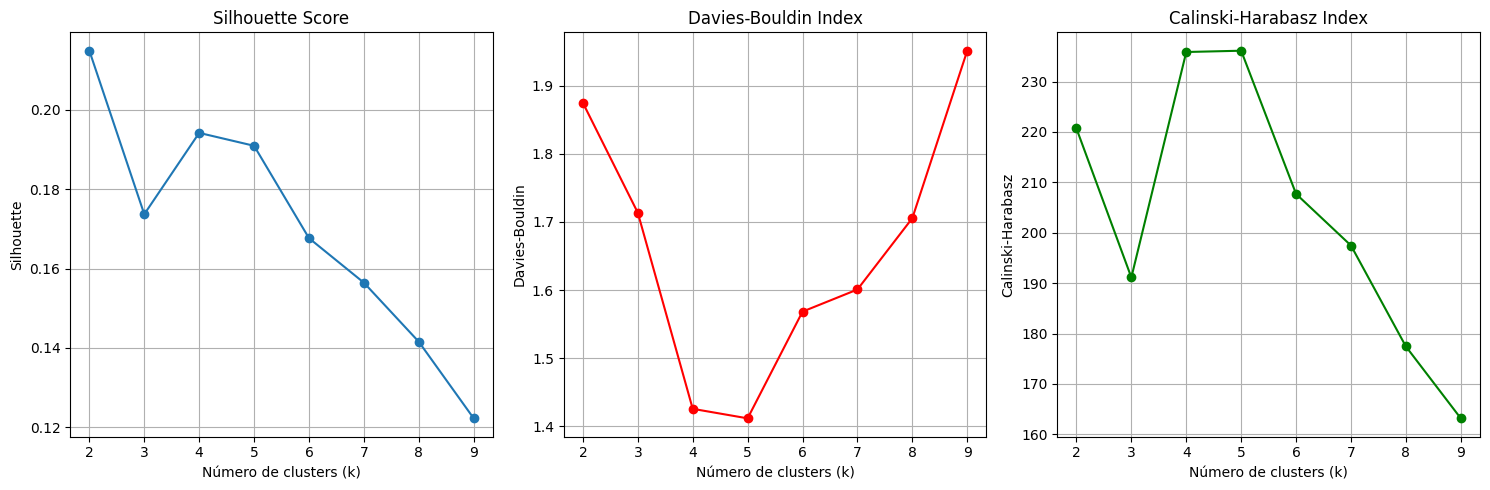

In [ ]:
from matplotlib import pyplot as plt

scores = []
k_range = range(2, 10)

silhouette_scores = []
davies_scores = []
calinski_scores = []

for k in k_range:
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("cluster", KMeans(n_clusters=k, random_state=42))
    ])
    pipeline.fit(X)
    labels = pipeline.named_steps["cluster"].labels_

    # Convertir a array denso para Davies-Bouldin y Calinski-Harabasz
    X_transformed = pipeline.named_steps["preprocessor"].transform(X).toarray()

    # Calcular métricas
    silhouette_scores.append(silhouette_score(pipeline.named_steps["preprocessor"].transform(X), labels))
    davies_scores.append(davies_bouldin_score(X_transformed, labels))
    calinski_scores.append(calinski_harabasz_score(X_transformed, labels))

# Graficar resultados
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, silhouette_scores, marker="o")
plt.title("Silhouette Score")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(k_range, davies_scores, marker="o", color="red")
plt.title("Davies-Bouldin Index")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Davies-Bouldin")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(k_range, calinski_scores, marker="o", color="green")
plt.title("Calinski-Harabasz Index")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Calinski-Harabasz")
plt.grid(True)

plt.tight_layout()
plt.show()

🔎 Cómo interpretarlo

Silhouette Score → elige el máximo.

Davies-Bouldin → elige el mínimo.

Calinski-Harabasz → elige el máximo.

In [51]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("cluster", KMeans(n_clusters=4, random_state=42))
])
pipeline.fit(X)
labels = pipeline.named_steps["cluster"].labels_

# Convertir a array denso para Davies-Bouldin y Calinski-Harabasz
X_transformed = pipeline.named_steps["preprocessor"].transform(X).toarray()



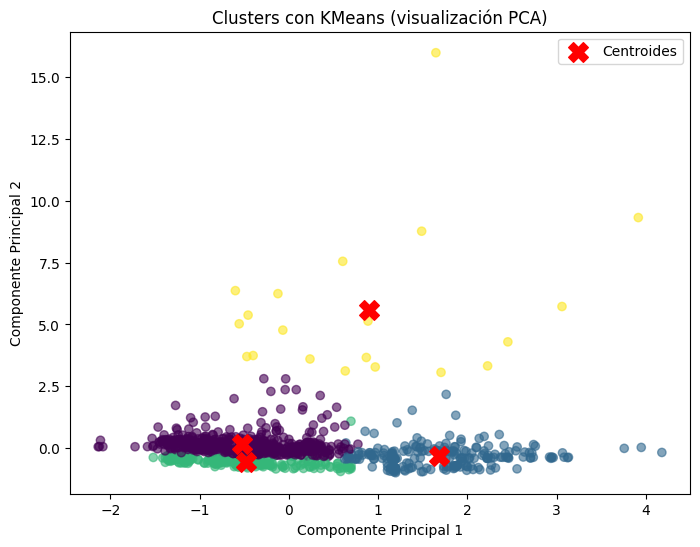

In [52]:
from sklearn.decomposition import PCA

# Reducir a 2 dimensiones para visualizar
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_transformed)

# Graficar clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="viridis", alpha=0.6)
plt.scatter(pca.transform(pipeline.named_steps["cluster"].cluster_centers_)[:,0],
            pca.transform(pipeline.named_steps["cluster"].cluster_centers_)[:,1],
            c="red", marker="X", s=200, label="Centroides")
plt.title("Clusters con KMeans (visualización PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.show()